In [284]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot,init_notebook_mode 
from plotly.tools import make_subplots
import plotly.offline as py
init_notebook_mode(connected=True)
from sklearn import preprocessing
from time import time
import math

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model, metrics 
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

%matplotlib inline

## Data Overview

In [2]:
train = pd.read_csv('Fraud_Data.csv')
ip_train = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
train.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0

In [4]:
ip_train.head()

lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China

In [5]:
print(train.shape)
print('\n')
print(ip_train.shape)

(151112, 11)


(138846, 3)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
train['signup_time']= pd.to_datetime(train['signup_time'])
train['purchase_time']= pd.to_datetime(train['purchase_time'])

### Missing Data

In [8]:
def missing_exploration(data):
    total= data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/ data.isnull().count() * 100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis= 1, keys=["Total","Percent"])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data

In [9]:
missing_exploration(train)

Empty DataFrame
Columns: [Total, Percent]
Index: []

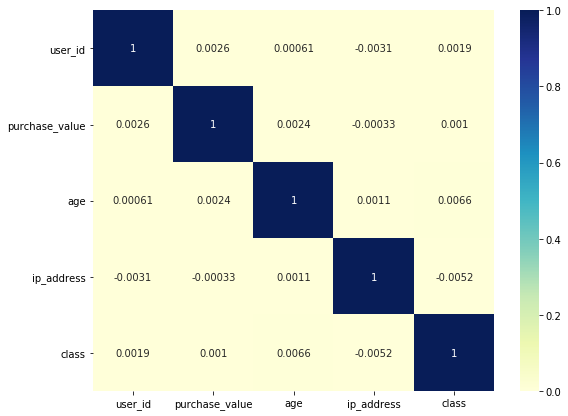

In [10]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corrmat,cmap = "YlGnBu",  annot=True ,vmin=0, vmax=1)

### Process IP Data

In [11]:
# Solution 1
def getCountry(ip):
    try :
        return ip_train.country[(ip_train.lower_bound_ip_address < ip)                            
                                & (ip_train.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return np.nan
train["IP_Country"] = train["ip_address"].apply(getCountry)
train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class     IP_Country  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0            NaN  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States

In [45]:
# Solution 2

ip = train["ip_address"].unique()
lower = ip_train["lower_bound_ip_address"].values
upper = ip_train["upper_bound_ip_address"].values
#country = ip_train["country"].values

ip_range = list(zip(lower, upper))
ip_range.sort(reverse=False)



def findCountry(IP,addr):
    if len(IP) == 1:
        #print("IP address:", addr)
        #print('\n')
        ip_country[addr] = np.nan
    else:
        mid = len(IP) //2
        #print("IP address:", addr)
        #print('\n')
        #print('Mid index: ', mid)
        #print('\n')
        first_haft = IP[:mid]
        second_haft = IP[mid:]
        if addr >= IP[mid][0] and addr <= IP[mid][1]:
            ip_country[addr] = ip_train.loc[ip_train["lower_bound_ip_address"] == IP[mid][0]]["country"].values
            #print("Lower IP: {} and Upper IP: {} \n".format(IP[mid][0], IP[mid][1]))
        elif addr > IP[mid][1]:
            #print("Upper IP: {} \n".format(IP[mid][1]))
            findCountry(second_haft, addr)
        elif addr < IP[mid][0]:
            #print("Lower IP: {}".format(IP[mid][0]))
            #print("--------------")
            findCountry(first_haft, addr)
    return ip_country

ip_country = {}
for i in ip:
    findCountry(ip_range,i)
ip_country_df =  pd.DataFrame(list(ip_country.items()),columns = ['ip_address','country'])


In [46]:
ip_country_df.head()

ip_address          country
0  7.327584e+08          [Japan]
1  3.503114e+08  [United States]
2  2.621474e+09  [United States]
3  3.840542e+09              NaN
4  4.155831e+08  [United States]

## EDA

###  Class

no fraud    136961
fraud        14151
Name: class, dtype: int64


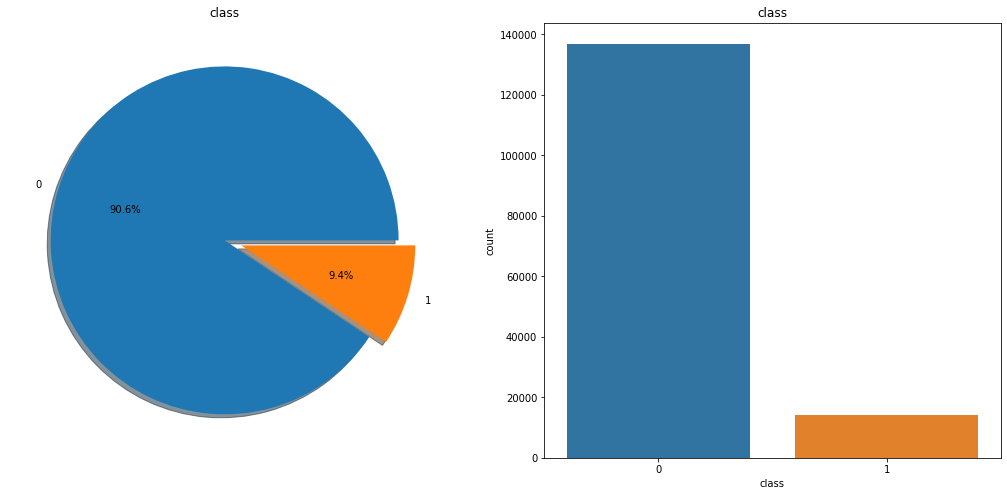

In [12]:
print(train["class"].value_counts().rename({0: 'no fraud',
                                      1: 'fraud',}))

f,ax=plt.subplots(1,2,figsize=(18,8))
train['class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('class')
ax[0].set_ylabel('')
sns.countplot('class',data=train,ax=ax[1])
ax[1].set_title('class')
plt.show()

### Gender

M    88293
F    62819
Name: sex, dtype: int64


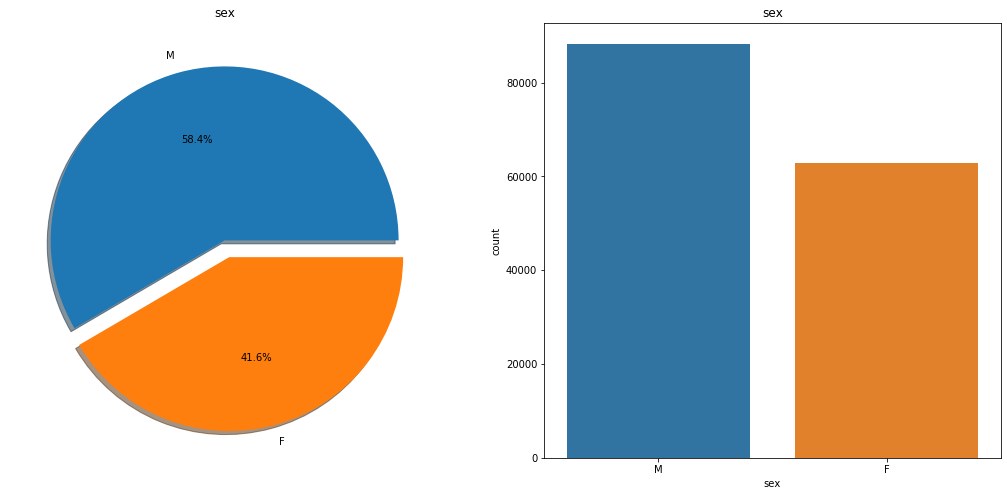

In [13]:
print(train["sex"].value_counts())

f,ax=plt.subplots(1,2,figsize=(18,8))
train['sex'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('sex')
ax[0].set_ylabel('')
sns.countplot('sex',data=train,ax=ax[1])
ax[1].set_title('sex')
plt.show()

### Age

In [14]:
train["age"].describe(percentiles = [0.05 * i for i in range(20)] + [0.99])

count    151112.000000
mean         33.140704
std           8.617733
min          18.000000
0%           18.000000
5%           20.000000
10%          22.000000
15%          24.000000
20%          25.000000
25%          27.000000
30%          28.000000
35%          29.000000
40%          30.000000
45%          31.000000
50%          33.000000
55%          34.000000
60%          35.000000
65%          36.000000
70%          37.000000
75%          39.000000
80%          40.000000
85%          42.000000
90%          45.000000
95%          48.000000
99%          55.000000
max          76.000000
Name: age, dtype: float64

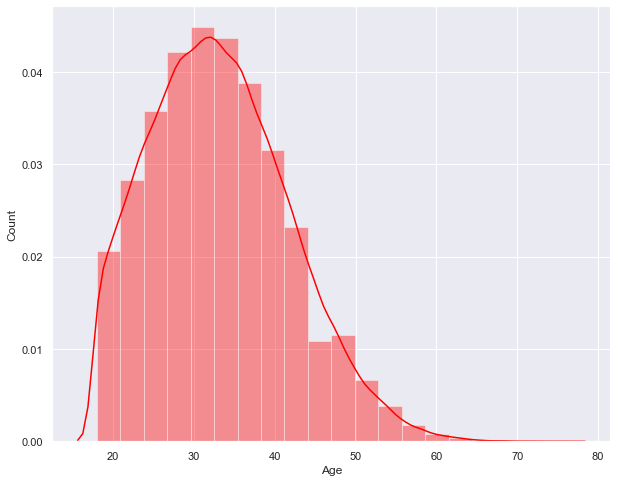

In [15]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [10, 8]})
sns.distplot(train['age'], bins =20, norm_hist=False,color = "red")\
.set(xlabel='Age', ylabel='Count');

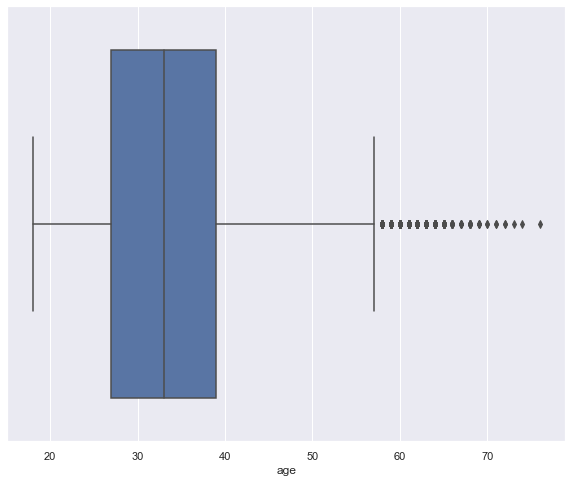

In [16]:
sns.boxplot(train['age'])

### Purchase Value

In [17]:
train["purchase_value"].describe(percentiles = [0.05 * i for i in range(20)] + [0.99])

count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
0%            9.000000
5%           12.000000
10%          15.000000
15%          17.000000
20%          20.000000
25%          22.000000
30%          25.000000
35%          27.000000
40%          30.000000
45%          32.000000
50%          35.000000
55%          37.000000
60%          40.000000
65%          43.000000
70%          45.000000
75%          49.000000
80%          52.000000
85%          57.000000
90%          62.000000
95%          70.000000
99%          87.000000
max         154.000000
Name: purchase_value, dtype: float64

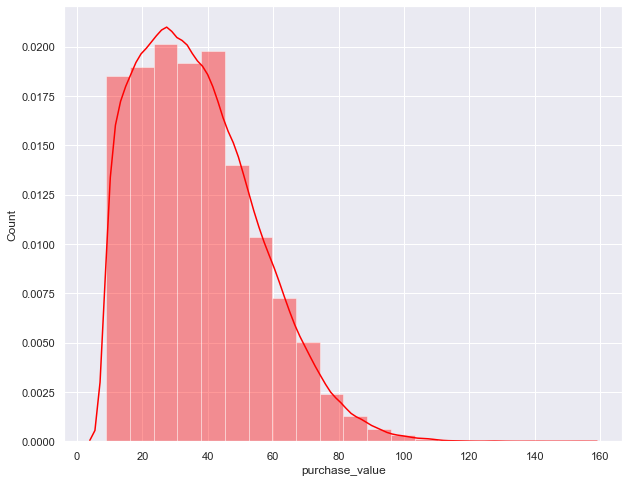

In [18]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [10, 8]})
sns.distplot(train['purchase_value'], bins =20, norm_hist=False,color = "red")\
.set(xlabel='purchase_value', ylabel='Count');

### Source, Brower

In [19]:
train['source'].value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [20]:
train['browser'].value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

### Multi Feature

#### Class with Gender

In [21]:
pd.crosstab(train['class'],train['sex'],margins=True).style.background_gradient(cmap='summer_r')

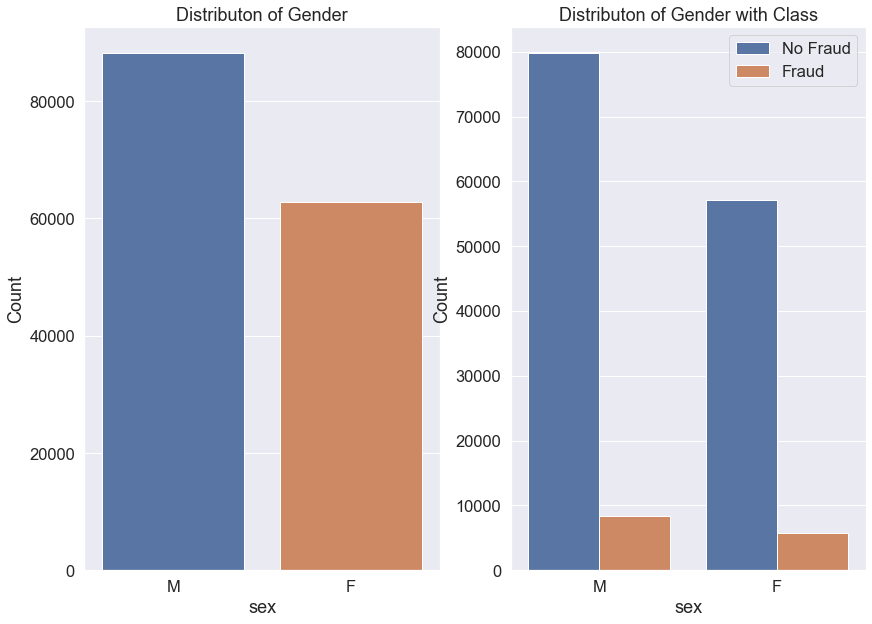

In [94]:
label = ["No Fraud", "Fraud"]
f, ax = plt.subplots(1,2, figsize = (14,10))
sns.countplot(x = 'sex', data = train, ax = ax[0])
ax[0].set_title("Distributon of Gender")
ax[0].set_ylabel("Count")
sns.countplot(x = 'sex', hue= 'class',data = train, ax = ax[1])
ax[1].set_title("Distributon of Gender with Class")
ax[1].set_ylabel("Count")
ax[1].legend(label)
plt.show()

#### Class with Age

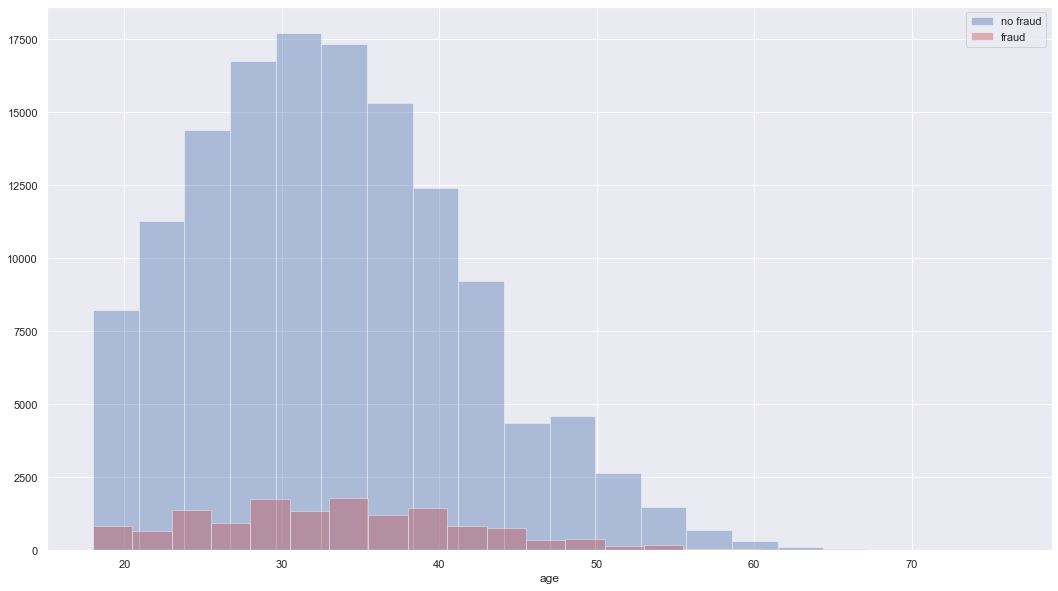

In [23]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [18, 10]})
sns.distplot(train[train['class']==0].age,bins=20, kde=False, color='b', label='no fraud')
sns.distplot(train[train['class']==1].age,bins=20, kde=False, color='r',label='fraud')
plt.legend()

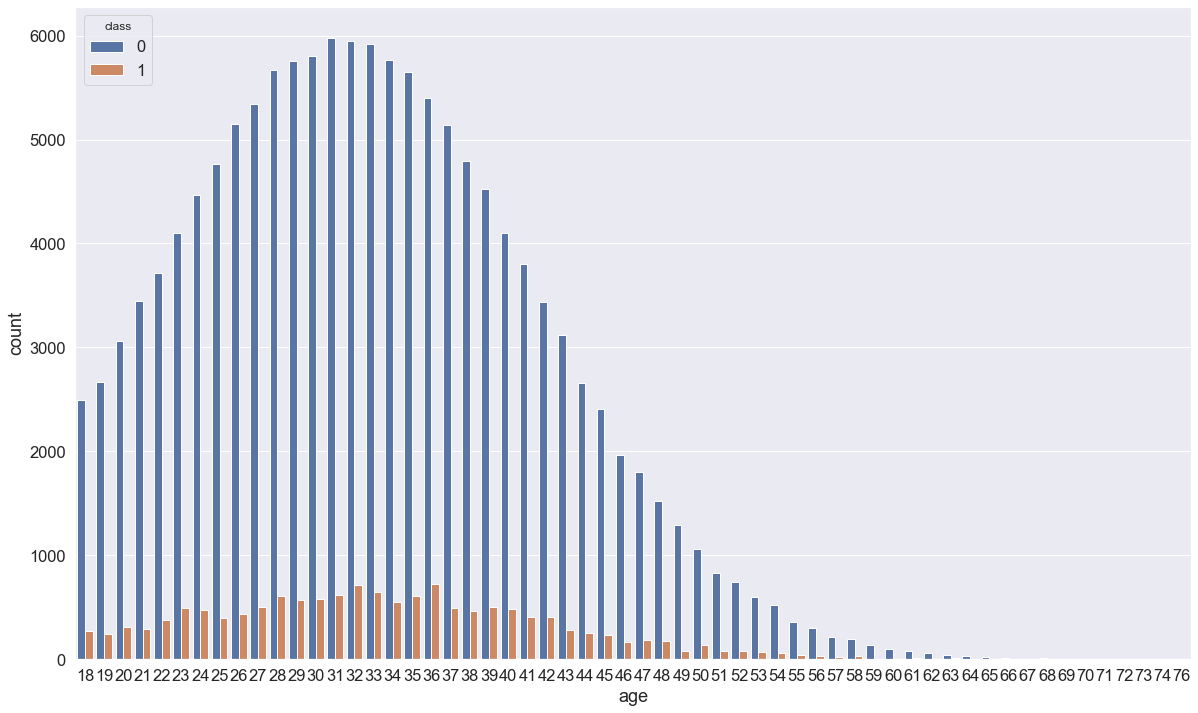

In [24]:
#pd.crosstab(train['age'],train['class'],margins=True).sort_values('All', ascending = False).style.background_gradient(cmap='summer_r')
sns.set(style='darkgrid', font_scale=1.5, rc={"figure.figsize": [20, 12]})
sns.countplot(x = 'age', hue = 'class', data = train)

In [25]:
pd.crosstab(train['source'], train['class'], margins=True).style.background_gradient(cmap='summer_r')

In [26]:
pd.crosstab(train['browser'], train['class'], margins=True).style.background_gradient(cmap='summer_r')

#### Processing Time Data

In [27]:
# Get different time between signup time and purchase time
train['difftime_sign_purchase'] = train['purchase_time'] - train['signup_time']
train['difftime_sign_purchase'] = train["difftime_sign_purchase"] / np.timedelta64(1, 'h')


# Get day,day of week, month, year of the purchase time

train['year_purchase'] = train.purchase_time.dt.year
train['month_purchase'] = train.purchase_time.dt.month
train['day_purchase'] = train.purchase_time.dt.day
train['hour_purchase'] = train.purchase_time.dt.hour
train['dayofweek'] = train['purchase_time'].dt.dayofweek

# Time point of the day 
train["timepoint_of_the_day"] = train.hour_purchase.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 7 else
                                                             "morning" if x < 11 else
                                                             "early afternoon" if x < 16 else
                                                             "afternoon" if x < 18 else
                                                             "evening"
                                                            )

train['dayofweek'] =train.dayofweek.apply(lambda x :  "Mon" if x == 0 else
                                                             "Tue" if x ==1 else
                                                             "Wed" if x ==2 else
                                                             "Thu" if x == 3 else
                                                             "Fri" if x == 4 else
                                                             "Sat" if x == 5 else
                                                             "Sun" 
                                                            )

train['month_purchase'] =train.month_purchase.apply(lambda x :  "Jan" if x == 1 else
                                                             "Feb" if x ==2 else
                                                             "Mar" if x ==3 else
                                                             "Apr" if x == 4 else
                                                             "May" if x == 5 else
                                                             "Jun" if x == 6 else
                                                             "Jul" if x == 7 else
                                                             "Aug" if x ==8 else
                                                             "Sep" if x ==9 else
                                                             "Oct" if x == 10 else
                                                             "Nov" if x == 11 else
                                                             "Dec" 
                                                            )

# The Purchase time is oliday or Working day??
train['Workingday'] = train["dayofweek"].apply(lambda x : 'Holiday' if x == 'Sun' or x == 'Sat' else 'Workday')


train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class     IP_Country  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0            NaN   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States   

   difftime_sign_purchase  year_purchase  month_purchase  day_purchase  \
0             1251.856111           2015               4            18   
1                4.984444           2015               6             8   
2                0.000278           2015               1             1   
3              136.690278           2015               5             4   
4             1211.516944           2015               9             9   

   hour_purchase dayofweek timepoint_of_the_day Workingday  
0              2       Sat           late night    Holiday  
1              1       Mon           late night    Workday  
2             18       Thu              evening    Workday  
3             13       Mon      early afternoon    Workday  
4             18       Wed              evening    Workday

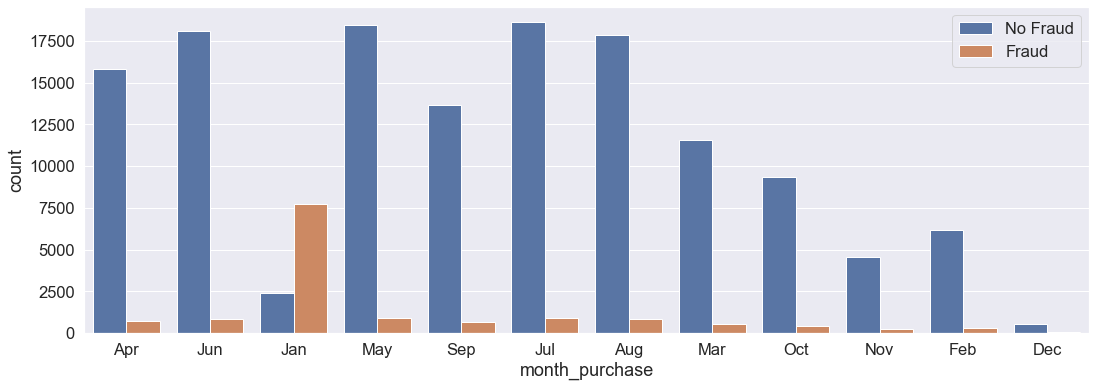

In [163]:
sns.set(style='darkgrid', font_scale=1.5)
sns.countplot(x = 'month_purchase', hue = 'class', data = train)
plt.legend(label)
plt.show()

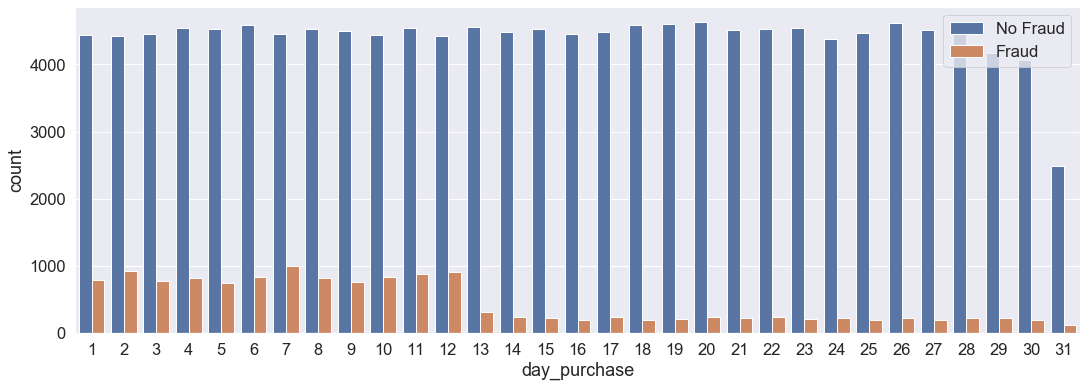

In [105]:
sns.countplot(x = 'day_purchase', hue = 'class', data = train)
plt.legend(label)
plt.show()

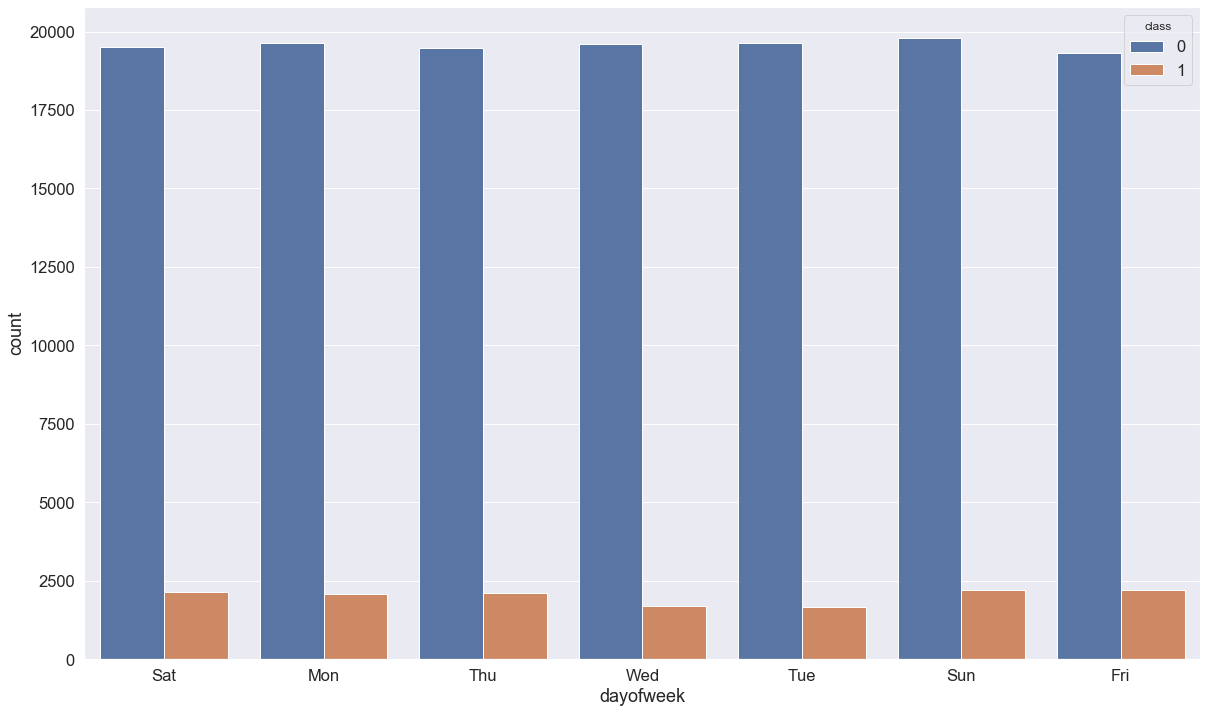

In [34]:
sns.set(style='darkgrid', font_scale=1.5)
sns.countplot(x = 'dayofweek', hue = 'class', data = train)

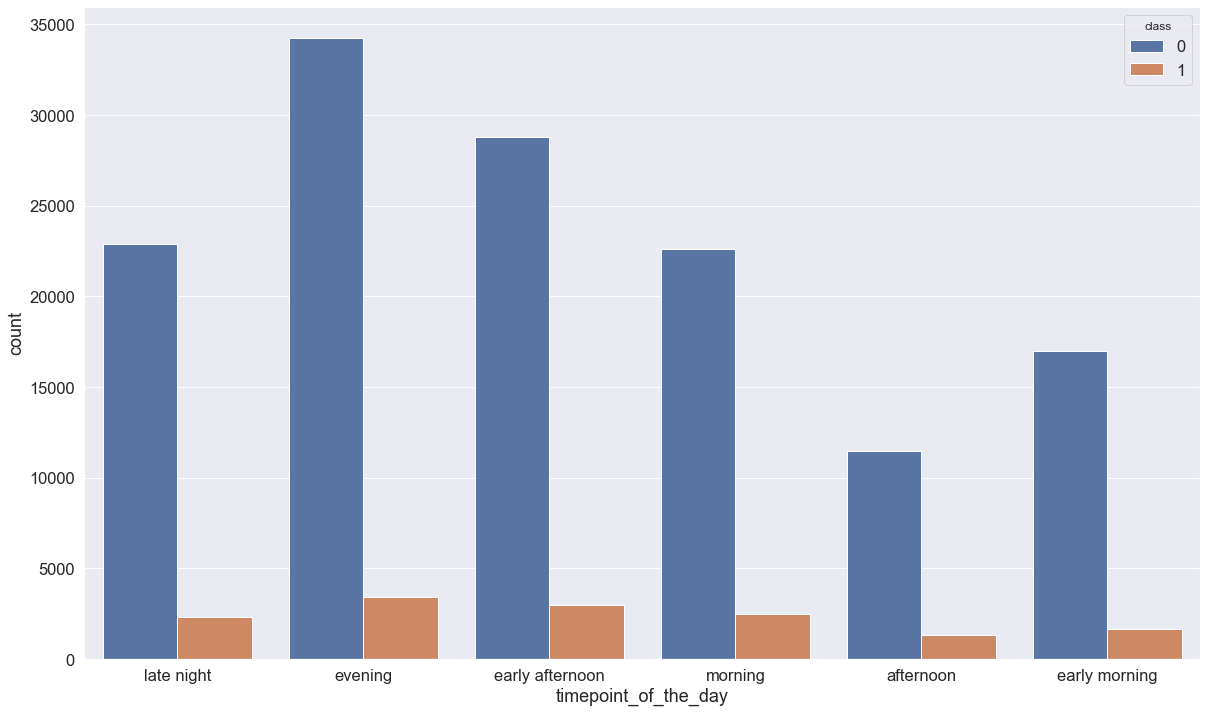

In [35]:
sns.countplot(x = 'timepoint_of_the_day', hue = train['class'], data = train)

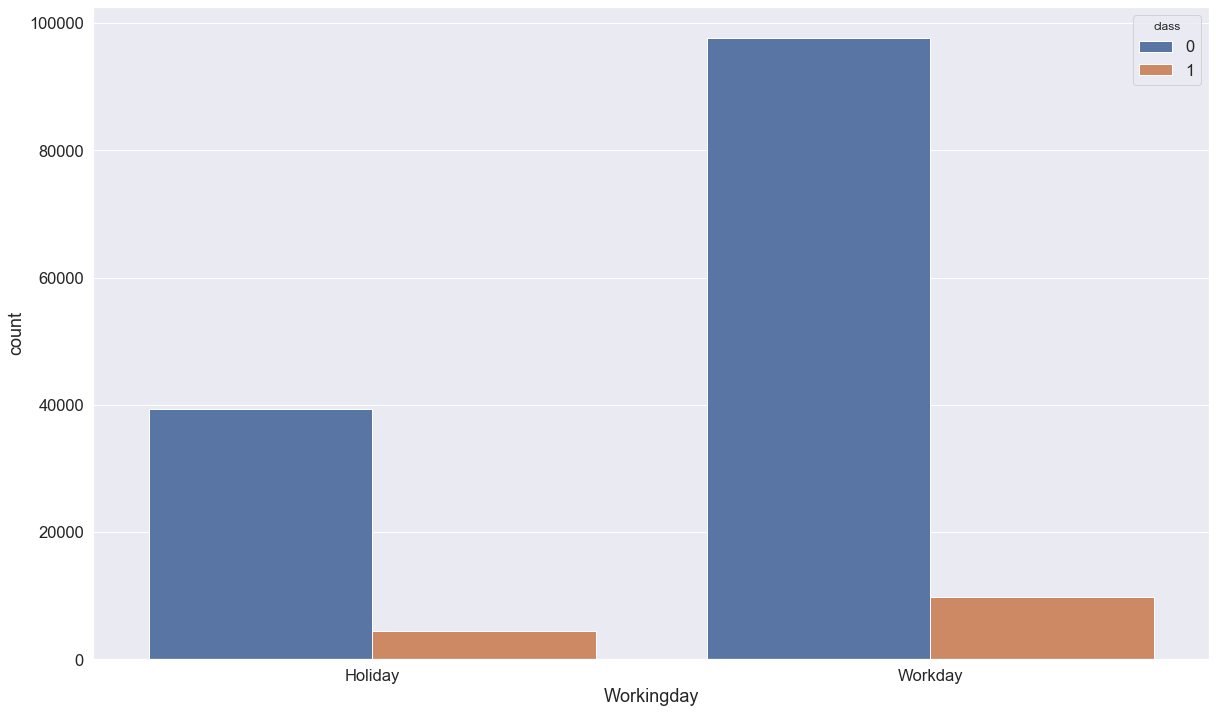

In [36]:
sns.countplot(x = 'Workingday', hue = train['class'], data = train)

#### Purchase value with Class

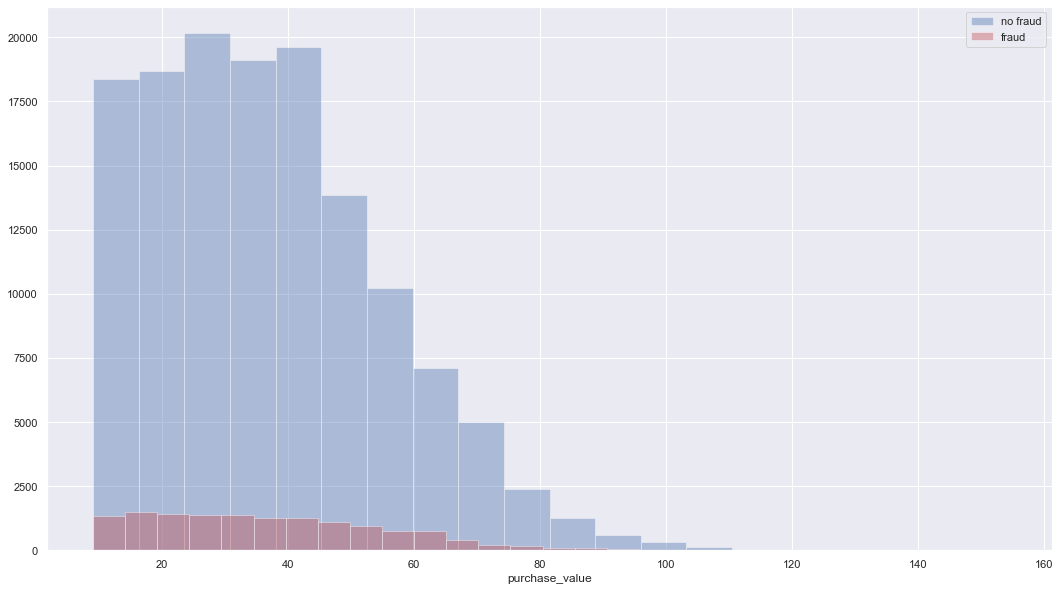

In [37]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [18, 10]})
sns.distplot(train[train['class']==0].purchase_value,bins=20, kde=False, color='b', label='no fraud')
sns.distplot(train[train['class']==1].purchase_value,bins=20, kde=False, color='r',label='fraud')
plt.legend()

In [159]:
#purchase_value_count = train.groupby([train['purchase_value']])['class'].count()
#purchase_value_count = purchase_value_count.to_frame().reset_index()
#purchase_value_count.columns = ['purchase_value','freq_purchase_value']
#train = pd.merge(train,purchase_value_count, how = 'left', on = 'purchase_value')
#train.head()

#### Device with class

In [38]:
pd.crosstab(train['device_id'],[train['class'], train['source']],margins=True).sort_values('All', ascending = False).head(30).style.background_gradient(cmap='summer_r')

In [40]:
device_count = train.groupby([train['device_id']])['class'].count()
device_count = device_count.to_frame().reset_index()
device_count.columns = ['device_id','num_trans_device']
train = pd.merge(train,device_count, how = 'left', on = 'device_id')
train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  ...     IP_Country  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08  ...          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08  ...  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09  ...  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09  ...            NaN   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08  ...  United States   

  difftime_sign_purchase  year_purchase  month_purchase  day_purchase  \
0            1251.856111           2015               4            18   
1               4.984444           2015               6             8   
2               0.000278           2015               1             1   
3             136.690278           2015               5             4   
4            1211.516944           2015               9             9   

   hour_purchase  dayofweek timepoint_of_the_day Workingday num_trans_device  
0              2        Sat           late night    Holiday                1  
1              1        Mon           late night    Workday                1  
2             18        Thu              evening    Workday               12  
3             13        Mon      early afternoon    Workday                1  
4             18        Wed              evening    Workday                1  

[5 rows x 21 columns]

In [74]:
#pd.crosstab(train['num_trans_device'], train['class'], margins=True).sort_values('All', ascending = False).style.background_gradient(cmap='summer_r')
#plt.figure(figsize=(20,16))
#label = ["No Fraud","Fraud"]
#g = sns.countplot(x = 'num_trans_device', hue = 'class', data = train, palette=sns.color_palette("Set3"))
#g.set_xticklabels(labels = sorted(train['num_trans_device'].unique()),rotation=0,ha='center')
#g.set_ylabel("Number of Class")
#g.set_title("Number of transaction each Device ID with Class")
#g.legend(label)
#sns.set_style({"axes.facecolor":"white"})

#total_count_dict = dict(train["num_trans_device"].value_counts().sort_index())
#plot_dict = {}

#for i in train["class"].unique():
#    value_count = dict(train.loc[train['class'] == i,"num_trans_device"].value_counts().sort_index())
#    for k, v in value_count.items():
#        if k not in plot_dict:
#            plot_dict[value_count[k]] = value_count[k]
#        else:
#            plot_dict[value_count[k]] = value_count[k]
#for p in g.patches:
#    height = p.get_height()
#    if math.isnan(height):
#        continue
#    g.text(p.get_x()+p.get_width()/2.0,height + 0.5, f"{plot_dict[height]:.0f}" , ha = "center", va = "bottom", fontsize = 10,weight="semibold",size="large")

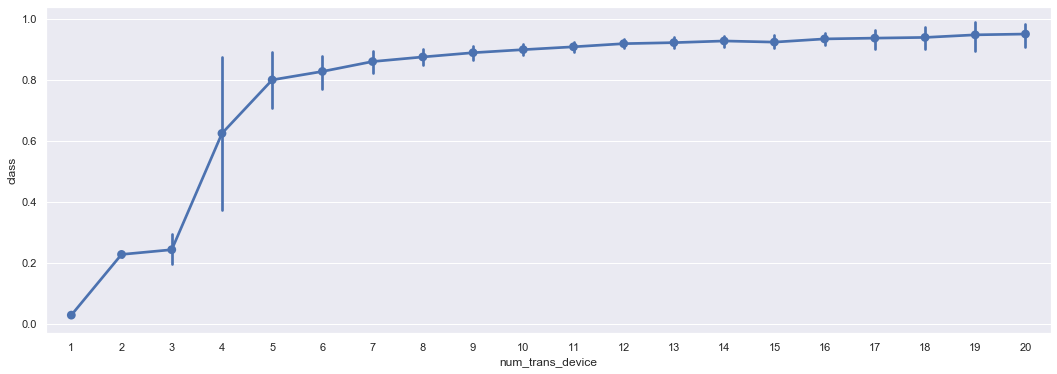

In [73]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [18, 6]})
sns.pointplot(train['num_trans_device'], train['class'], data = train,logistic=True)

In [106]:
#data = []
#for a in range(2):
#    df = train.loc[train['class'] == a]
#
#    data.append(go.Scatter(
#        x = df['num_trans_device'].value_counts().sort_index().index,
#        y = df['num_trans_device'].value_counts().sort_index().values,
#        name = str(a)
#    ))
#    
#layout = go.Layout(dict(title = "Class trends by num_trans_device",
#                  xaxis = dict(title = 'num_trans_device'),
#                  yaxis = dict(title = 'Counts'),
#                  )
#                  )
#py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [114]:
#train.loc[ train['num_trans_device'] <= 4, 'trans_num']          = 'No'
#train.loc[(train['num_trans_device'] > 4) , 'trans_num']        = 'Yes'
train.loc[train["device_id"] =='GDATAKTYQUGWR']
#train.loc[train["num_trans_device"] ==2]

user_id         signup_time       purchase_time  purchase_value  \
45      313833 2015-08-16 20:48:52 2015-11-17 09:43:11              12   
59667   206651 2015-05-11 16:51:54 2015-06-02 14:06:34              56   

           device_id source browser sex  age    ip_address  ...  \
45     GDATAKTYQUGWR    Ads      IE   M   55  5.690384e+08  ...   
59667  GDATAKTYQUGWR    Ads  Chrome   F   33  3.036948e+09  ...   

       difftime_sign_purchase year_purchase  month_purchase  day_purchase  \
45                2220.905278          2015              11            17   
59667              525.244444          2015               6             2   

       hour_purchase  dayofweek  timepoint_of_the_day Workingday  \
45                 9        Tue               morning    Workday   
59667             14        Tue       early afternoon    Workday   

      num_trans_device ratio_class_country  
45                   2            0.095626  
59667                2            0.099849  

[2 rows x 22 columns]

#### Country with Class

In [135]:
train.drop(['ratio_class_country'], axis = 1 ,inplace=True)

In [139]:
#train["IP_Country"].fillna('Unknow', inplace = True)
ratio_class_country = pd.DataFrame(train.groupby(by="IP_Country").mean()["class"].sort_values())
ratio_class_country.reset_index()
ratio_class_country.rename(columns={'class':'ratio_class_country'},inplace = True)
train = train.merge(ratio_class_country, how = 'left', on = 'IP_Country' )
train.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  ...  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08  ...   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08  ...   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09  ...   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09  ...   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08  ...   

   difftime_sign_purchase year_purchase  month_purchase  day_purchase  \
0             1251.856111          2015               4            18   
1                4.984444          2015               6             8   
2                0.000278          2015               1             1   
3              136.690278          2015               5             4   
4             1211.516944          2015               9             9   

   hour_purchase  dayofweek  timepoint_of_the_day Workingday num_trans_device  \
0              2        Sat            late night    Holiday                1   
1              1        Mon            late night    Workday                1   
2             18        Thu               evening    Workday               12   
3             13        Mon       early afternoon    Workday                1   
4             18        Wed               evening    Workday                1   

  ratio_class_country  
0            0.097865  
1            0.095626  
2            0.095626  
3            0.085723  
4            0.095626  

[5 rows x 22 columns]

In [147]:
train["rank_ratio_country"] = train["ratio_class_country"].apply(lambda x: 'Very High' if x > 0.2 else
                                                                            'High' if x > 0.05 else
                                                                            'Medium' if x > 0.02 else
                                                                            'Low')

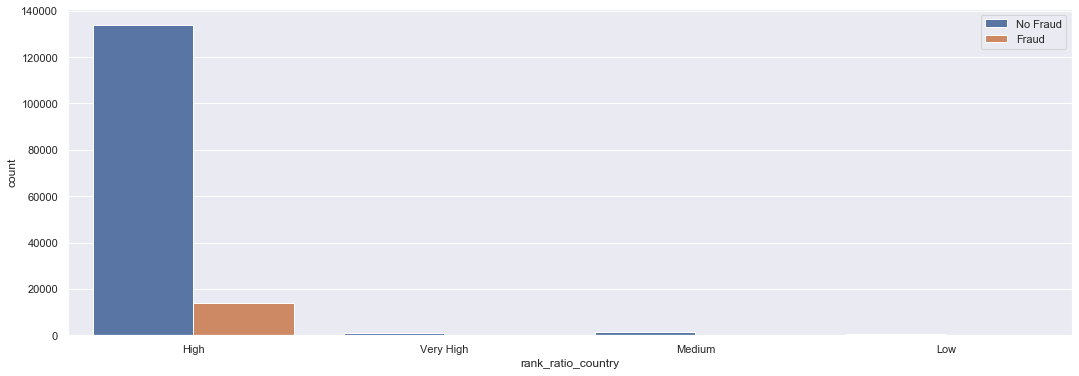

In [149]:
sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [18, 6]})
sns.countplot(x = 'rank_ratio_country', hue = 'class', data= train)
plt.legend(label)
plt.show()

## Data Preprocess

In [164]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 151112 non-null  int64         
 1   signup_time             151112 non-null  datetime64[ns]
 2   purchase_time           151112 non-null  datetime64[ns]
 3   purchase_value          151112 non-null  int64         
 4   device_id               151112 non-null  object        
 5   source                  151112 non-null  object        
 6   browser                 151112 non-null  object        
 7   sex                     151112 non-null  object        
 8   age                     151112 non-null  int64         
 9   ip_address              151112 non-null  float64       
 10  class                   151112 non-null  int64         
 11  IP_Country              151112 non-null  object        
 12  difftime_sign_purchase  151112

In [238]:
train_preprocess = train.copy()

### Preprocess Numerical Data

In [239]:
drop_feature = ['user_id','signup_time','purchase_time','device_id','ip_address',
                'ratio_class_country','year_purchase','hour_purchase']
train_preprocess = train_preprocess.drop(drop_feature, axis=1)

In [240]:
train_preprocess['age_group'] = train_preprocess['age'].apply(lambda x: '18-40' if x < 40 else
                                                   '40-49' if x < 50 else
                                                    '50-59' if x < 60 else
                                                    '60++' )

In [241]:
train_preprocess.head()

purchase_value source browser sex  age  class     IP_Country  \
0              34    SEO  Chrome   M   39      0          Japan   
1              16    Ads  Chrome   F   53      0  United States   
2              15    SEO   Opera   M   53      1  United States   
3              44    SEO  Safari   M   41      0         Unknow   
4              39    Ads  Safari   M   45      0  United States   

   difftime_sign_purchase month_purchase  day_purchase dayofweek  \
0             1251.856111            Apr            18       Sat   
1                4.984444            Jun             8       Mon   
2                0.000278            Jan             1       Thu   
3              136.690278            May             4       Mon   
4             1211.516944            Sep             9       Wed   

  timepoint_of_the_day Workingday  num_trans_device rank_ratio_country  \
0           late night    Holiday                 1               High   
1           late night    Workday                 1               High   
2              evening    Workday                12               High   
3      early afternoon    Workday                 1               High   
4              evening    Workday                 1               High   

   freq_purchase_value age_group  
0                 3079     18-40  
1                 2722     50-59  
2                 2791     50-59  
3                 2517     40-49  
4                 2863     40-49

In [242]:
numerical = ['age','num_trans_device','purchase_value','difftime_sign_purchase',
             'day_purchase','num_trans_device','freq_purchase_value']

In [212]:
train_preprocess['difftime_sign_purchase'] = np.log1p(train_preprocess['difftime_sign_purchase'])
train_preprocess['freq_purchase_value'] = np.log1p(train_preprocess['freq_purchase_value'])

In [243]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
#min_max_scaler = preprocessing.MinMaxScaler()

In [244]:
train_preprocess[numerical] = scaler.fit_transform(train_preprocess[numerical])

In [245]:
train_preprocess.head()

purchase_value source browser sex       age  class     IP_Country  \
0       -0.160204    SEO  Chrome   M  0.679914      0          Japan   
1       -1.142592    Ads  Chrome   F  2.304476      0  United States   
2       -1.197169    SEO   Opera   M  2.304476      1  United States   
3        0.385567    SEO  Safari   M  0.911994      0         Unknow   
4        0.112681    Ads  Safari   M  1.376155      0  United States   

   difftime_sign_purchase month_purchase  day_purchase dayofweek  \
0               -0.136057            Apr      0.308768       Sat   
1               -1.571877            Jun     -0.825780       Mon   
2               -1.577617            Jan     -1.619963       Thu   
3               -1.420213            May     -1.279599       Mon   
4               -0.182509            Sep     -0.712325       Wed   

  timepoint_of_the_day Workingday  num_trans_device rank_ratio_country  \
0           late night    Holiday         -0.261514               High   
1           late night    Workday         -0.261514               High   
2              evening    Workday          3.941861               High   
3      early afternoon    Workday         -0.261514               High   
4              evening    Workday         -0.261514               High   

   freq_purchase_value age_group  
0             0.798415     18-40  
1             0.337972     50-59  
2             0.426965     50-59  
3             0.073571     40-49  
4             0.519827     40-49

### Preprocess Categorical Data

In [246]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_preprocess['IP_Country'] = labelencoder.fit_transform(train_preprocess["IP_Country"])

In [247]:
train_preprocess = pd.get_dummies(train_preprocess)

In [248]:
train_preprocess.head()

purchase_value       age  class  IP_Country  difftime_sign_purchase  \
0       -0.160204  0.679914      0          84               -0.136057   
1       -1.142592  2.304476      0         171               -1.571877   
2       -1.197169  2.304476      1         171               -1.577617   
3        0.385567  0.911994      0         172               -1.420213   
4        0.112681  1.376155      0         171               -0.182509   

   day_purchase  num_trans_device  freq_purchase_value  source_Ads  \
0      0.308768         -0.261514             0.798415           0   
1     -0.825780         -0.261514             0.337972           1   
2     -1.619963          3.941861             0.426965           0   
3     -1.279599         -0.261514             0.073571           0   
4     -0.712325         -0.261514             0.519827           1   

   source_Direct  ...  Workingday_Holiday  Workingday_Workday  \
0              0  ...                   1                   0   
1              0  ...                   0                   1   
2              0  ...                   0                   1   
3              0  ...                   0                   1   
4              0  ...                   0                   1   

   rank_ratio_country_High  rank_ratio_country_Low  rank_ratio_country_Medium  \
0                        1                       0                          0   
1                        1                       0                          0   
2                        1                       0                          0   
3                        1                       0                          0   
4                        1                       0                          0   

   rank_ratio_country_Very High  age_group_18-40  age_group_40-49  \
0                             0                1                0   
1                             0                0                0   
2                             0                0                0   
3                             0                0                1   
4                             0                0                1   

   age_group_50-59  age_group_60++  
0                0               0  
1                1               0  
2                1               0  
3                0               0  
4                0               0  

[5 rows x 53 columns]

In [249]:
train_preprocess.shape

(151112, 53)

## Model

In [250]:
y = train_preprocess['class']
x = train_preprocess.drop('class', axis=1)

In [251]:
x_train, x_test , y_train, y_test= train_test_split(x,y,test_size=0.2,random_state = 12)

In [252]:
print(x_train.shape)
print(y_train.shape)

(120889, 52)
(120889,)


In [253]:
print(x_test.shape)
print(y_test.shape)

(30223, 52)
(30223,)


In [254]:
def train_predict(model, X_train, y_train, X_test, y_test): 

    
    results = {}
    
    
    start = time() # Get start time
    model.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the total training time
    results['train_time'] = end - start
        
    
    start = time() # Get start time
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the train
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the train
    results['f_train'] = fbeta_score(y_train, predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    return results

In [255]:
clf_A  = xgb.XGBClassifier(objective ='binary:logistic', 
                 colsample_bytree = 0.8, 
                 learning_rate = 0.01,
                 subsample=0.8,
                 max_depth = 5, 
                 alpha = 10, 
                 n_estimators = 10)



In [256]:

clf_B = GradientBoostingClassifier(learning_rate = 0.01,
                                   subsample=0.8,
                                   max_depth=5,
                                   max_features = 11,
                                   random_state=0)

clf_C = GaussianNB()
clf_D = RandomForestClassifier(n_estimators=100)

results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
     results[clf] = train_predict(clf, x_train, y_train, x_test, y_test)

In [257]:
results

{XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0,
               learning_rate=0.01, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1): {'train_time': 2.095869779586792,
  'pred_time': 0.20890355110168457,
  'acc_train': 0.9568033485263341,
  'acc_test': 0.9560268669556298,
  'f_train': 0.8531785081676836,
  'f_test': 0.8520703472840606},
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.01, loss='deviance', max_depth=5,
                            max_features=11, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,

In [197]:
from xgboost import plot_importance
from matplotlib import pyplot

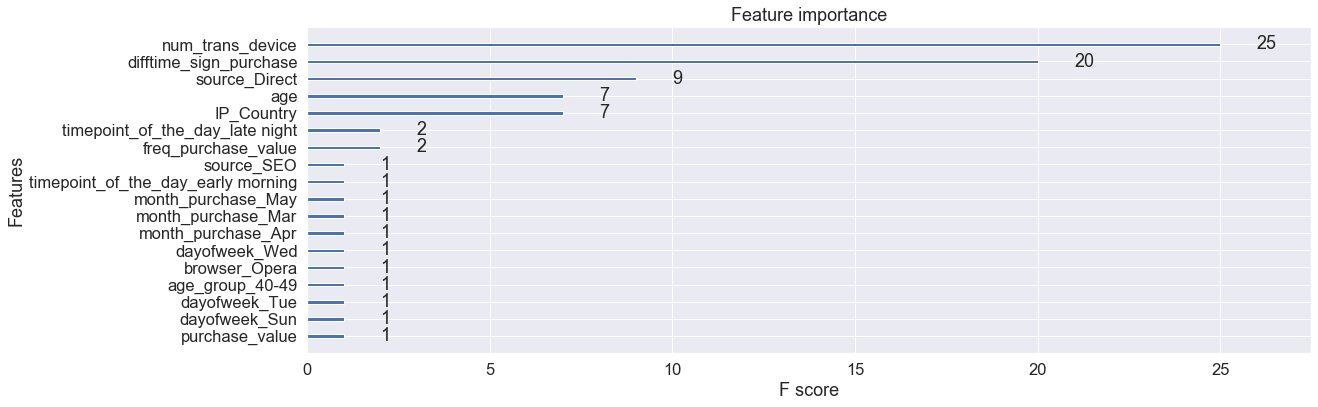

In [258]:
plot_importance(clf_A)
pyplot.show()

In [270]:
#predictions = clf_B.predict(x_test)

#print(accuracy_score(y_test,predictions))
#print('\n')
#print(classification_report(y_test,predictions))

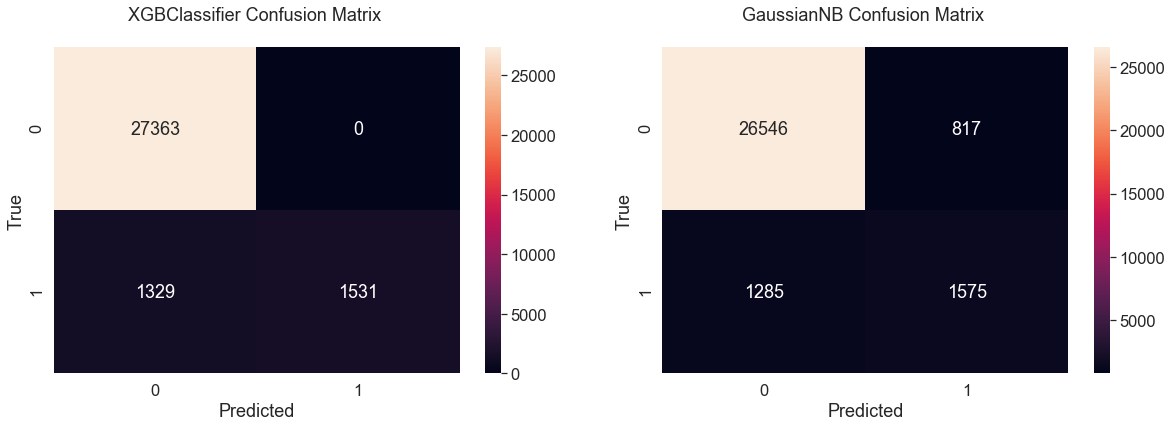

In [283]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,2, figsize = (20,6))
cm = confusion_matrix(y_test, clf_A.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d", ax = ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title("XGBClassifier Confusion Matrix \n")


cm = confusion_matrix(y_test, clf_C.predict(x_test))
sns.heatmap(cm, annot=True, fmt="d", ax = ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title("GaussianNB Confusion Matrix \n")

plt.show()

### Tuning Model

In [ ]:
clf = GradientBoostingClassifier(random_state=0)

parameters = { 'max_depth': np.arange(2,10,2), 
               'min_samples_leaf': [3, 5, 10], 
               'subsample' : np.arange(0.1, 1.1, 0.1),
               'max_features': np.arange(1,21),
               'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
               'max_depth' : np.arange(1,11),
               'n_estimators': [100, 200, 300, 400, 500]  }


scorer = make_scorer(fbeta_score, beta=0.5)

clf_tuning = GridSearchCV(clf, parameters, scoring=scorer, cv= 5)

grid_fit = clf_tuning.fit(x_train, y_train)

best_clf = grid_fit.best_estimator_


# Make predictions using the unoptimized and model
predictions = clf_B.predict(x_test)
tuning_predictions = best_clf.predict(x_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, tuning_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, tuning_predictions, beta = 0.5)))

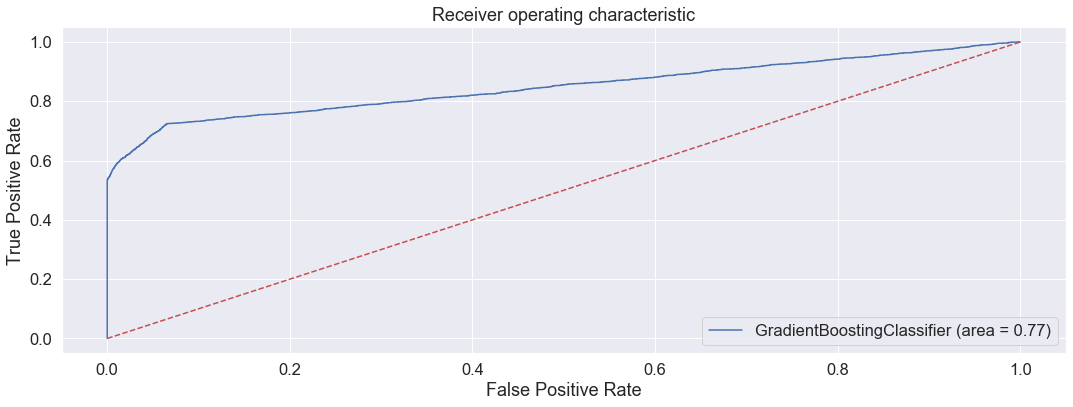

In [279]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
clf_B_roc_auc = roc_auc_score(y_test, clf_B.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_B.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GradientBoostingClassifier (area = %0.2f)' % clf_B_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()